## Predicting Heart Disease

### Introduction:

 

Heart disease is an umbrella term for a vast range of conditions that affect the heart. Stroke, heart attack, cardiomyopathy, and angina are all 
examples of heart disease (Heart&Stroke, 2023). Leading risk factors for heart disease are high blood pressure and cholesterol, obesity, unhealthy diet, and physical inactivity.
Based on a dataset from 1988 consisting of 4 databases, Cleveland, Hungary, Switzerland, and Long Beach V, heart disease could be predicted 
in a patient by looking at 14 attributes. Of these attributes, 5 will be observed in order to successfully determine the presence of heart disease
in a patient. The predictive question being asked is, "By considering age, exercise induced angina, serum cholesterol levels, and resting blood pressure, can heart disease in a patient be predicted?". 

### Preliminary Exploratory Data Analysis:


We first started by reading in the heart data, using read_csv as, the data was comma separated. Then, we selected the predictors we wanted use, and checked if there were any missing values in the data set using the "sum(is.na())" function.

In [32]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(ggplot2)
library(gridExtra)


heart_data <- read_csv("project_data/heart.csv")

heart_var <- heart_data |>
    select(age, exang, chol, cp, trestbps, target)
slice(heart_var, 1:5)
sum(is.na(heart_data))




Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,exang,chol,cp,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,0,212,0,125,0
53,1,203,0,140,0
70,1,174,0,145,0
61,0,203,0,148,0
62,0,294,0,138,0


[1] 0

From there, we split the data with the variables we selected into a training set with 75% of the data, and a testing set with 25% of the data. To see some of the data, we used the slice function to show the first five rows. 

In [33]:
set.seed(3456)

heart_split <- initial_split(heart_var, prop = 0.75, strata = target)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

slice(heart_train, 1:5)

age,exang,chol,cp,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53,1,203,0,140,0
70,1,174,0,145,0
61,0,203,0,148,0
46,0,249,0,120,0
43,1,341,0,132,0


Since some of the variables we chose have values representing a condition, e.g. the exercise induced angina variable uses a "1" to represent yes and "0" to represent no, we split them into their own smaller data frames that show the total number of a specific value to better visualize the data. Both the cp, chest pain, and exang, exercise induced angina variables were organized as such. For variables such as chol, serum cholesterol levels, and trestbps, resting blood pressure be found the number of individuals with a sepecific cholesterol level or blood pressure in a similar way to see the distribution of people.

In [34]:
cp_val <- heart_train |>
  group_by(cp)|>
  summarise(counts = n())
cp_val

exang_val <- heart_train |>
   group_by(exang)|>
   summarise(counts=n())
exang_val


chol_val <- heart_train |>
   group_by(chol)|>
   summarise(counts=n(),
            .groups = 'drop')
slice(chol_val, (1:3))

trestbps_val <- heart_train |> 
       group_by(trestbps) |> 
  summarise(counts=n(),
            .groups = 'drop')
slice(trestbps_val, (1:3))




cp,counts
<dbl>,<int>
0,380
1,124
2,209
3,55


exang,counts
<dbl>,<int>
0,510
1,258


chol,counts
<dbl>,<int>
126,2
131,1
141,3


trestbps,counts
<dbl>,<int>
94,4
100,8
101,3


From here, we could better visualize what the distributions of the data looks like by creating individual graphs that present each variable. To do so, we chose bar graphs as, we found the sum of individuals for a specific value for each variable. Using a bar graph would make the distinctions clearer.

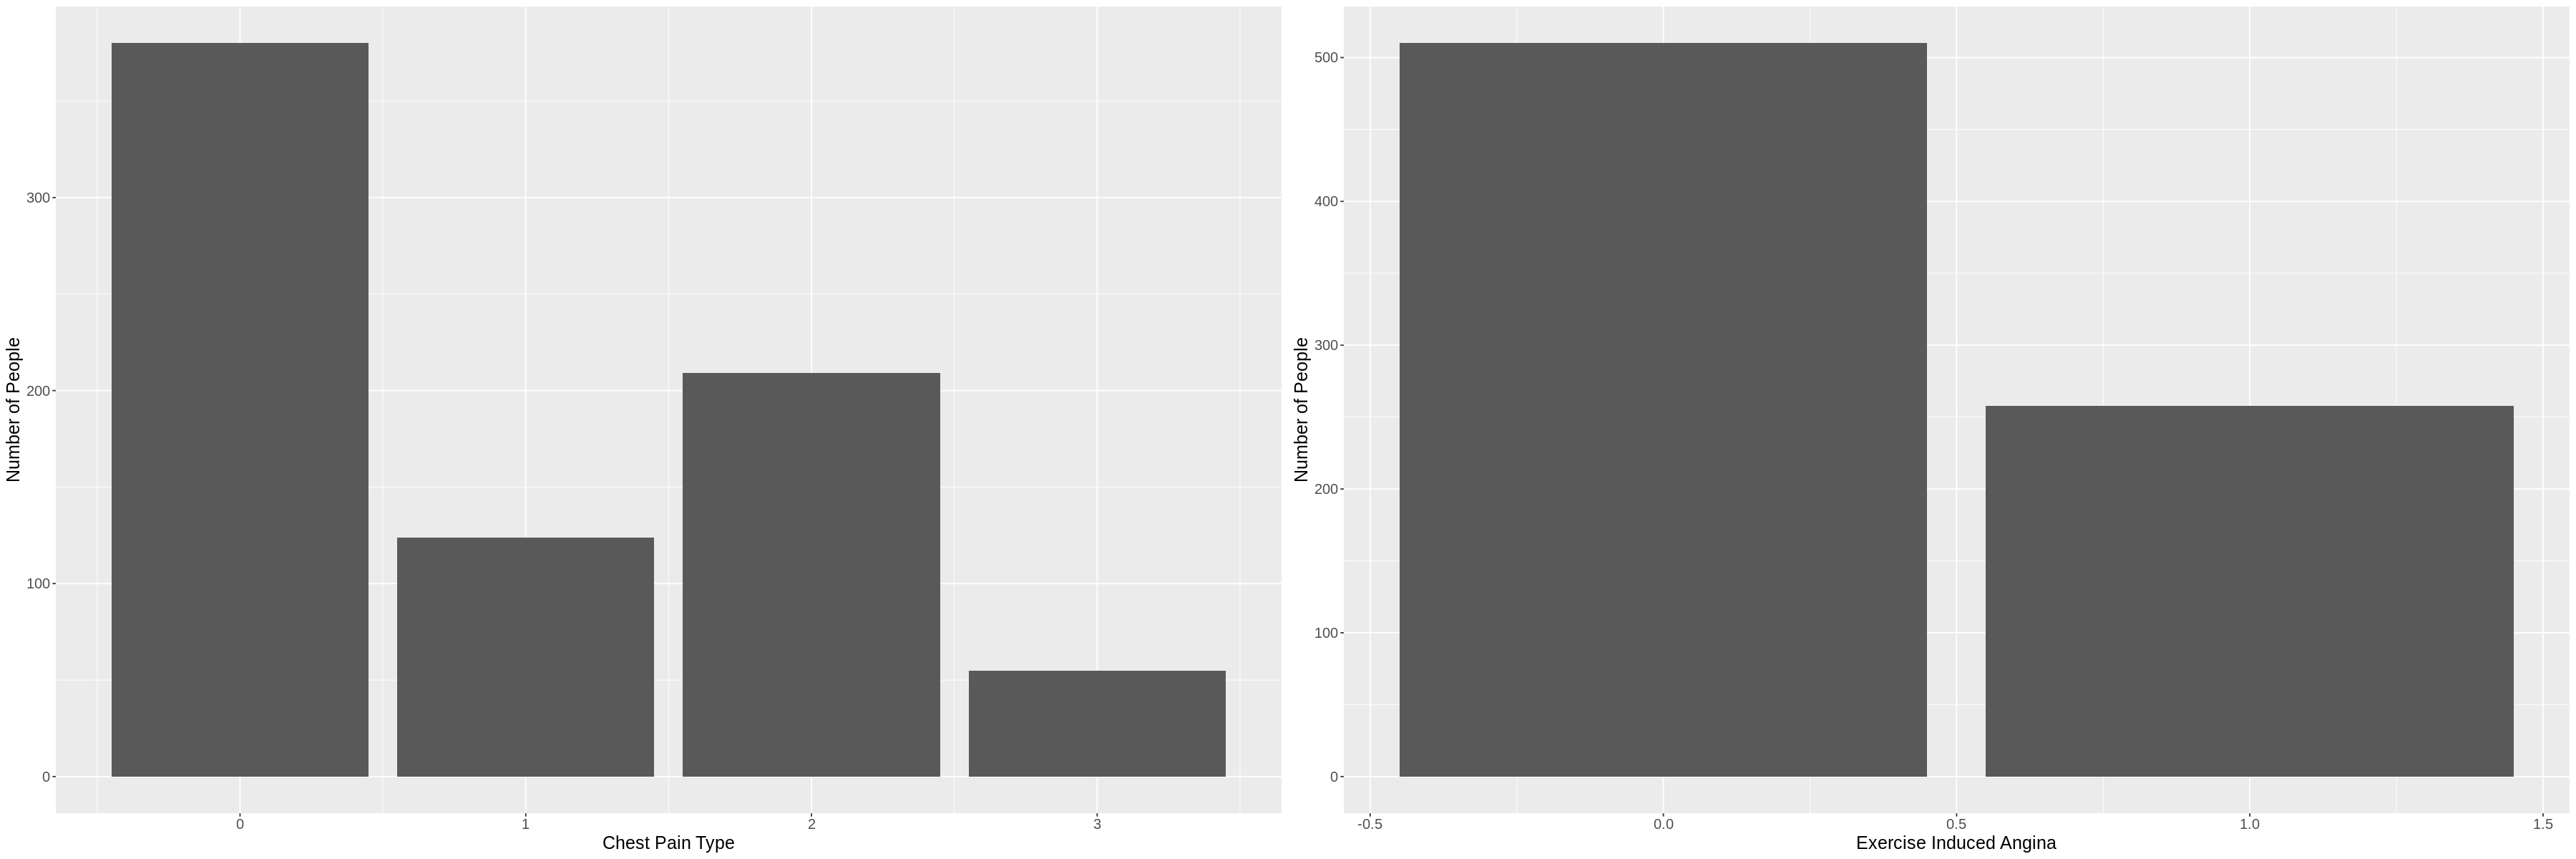

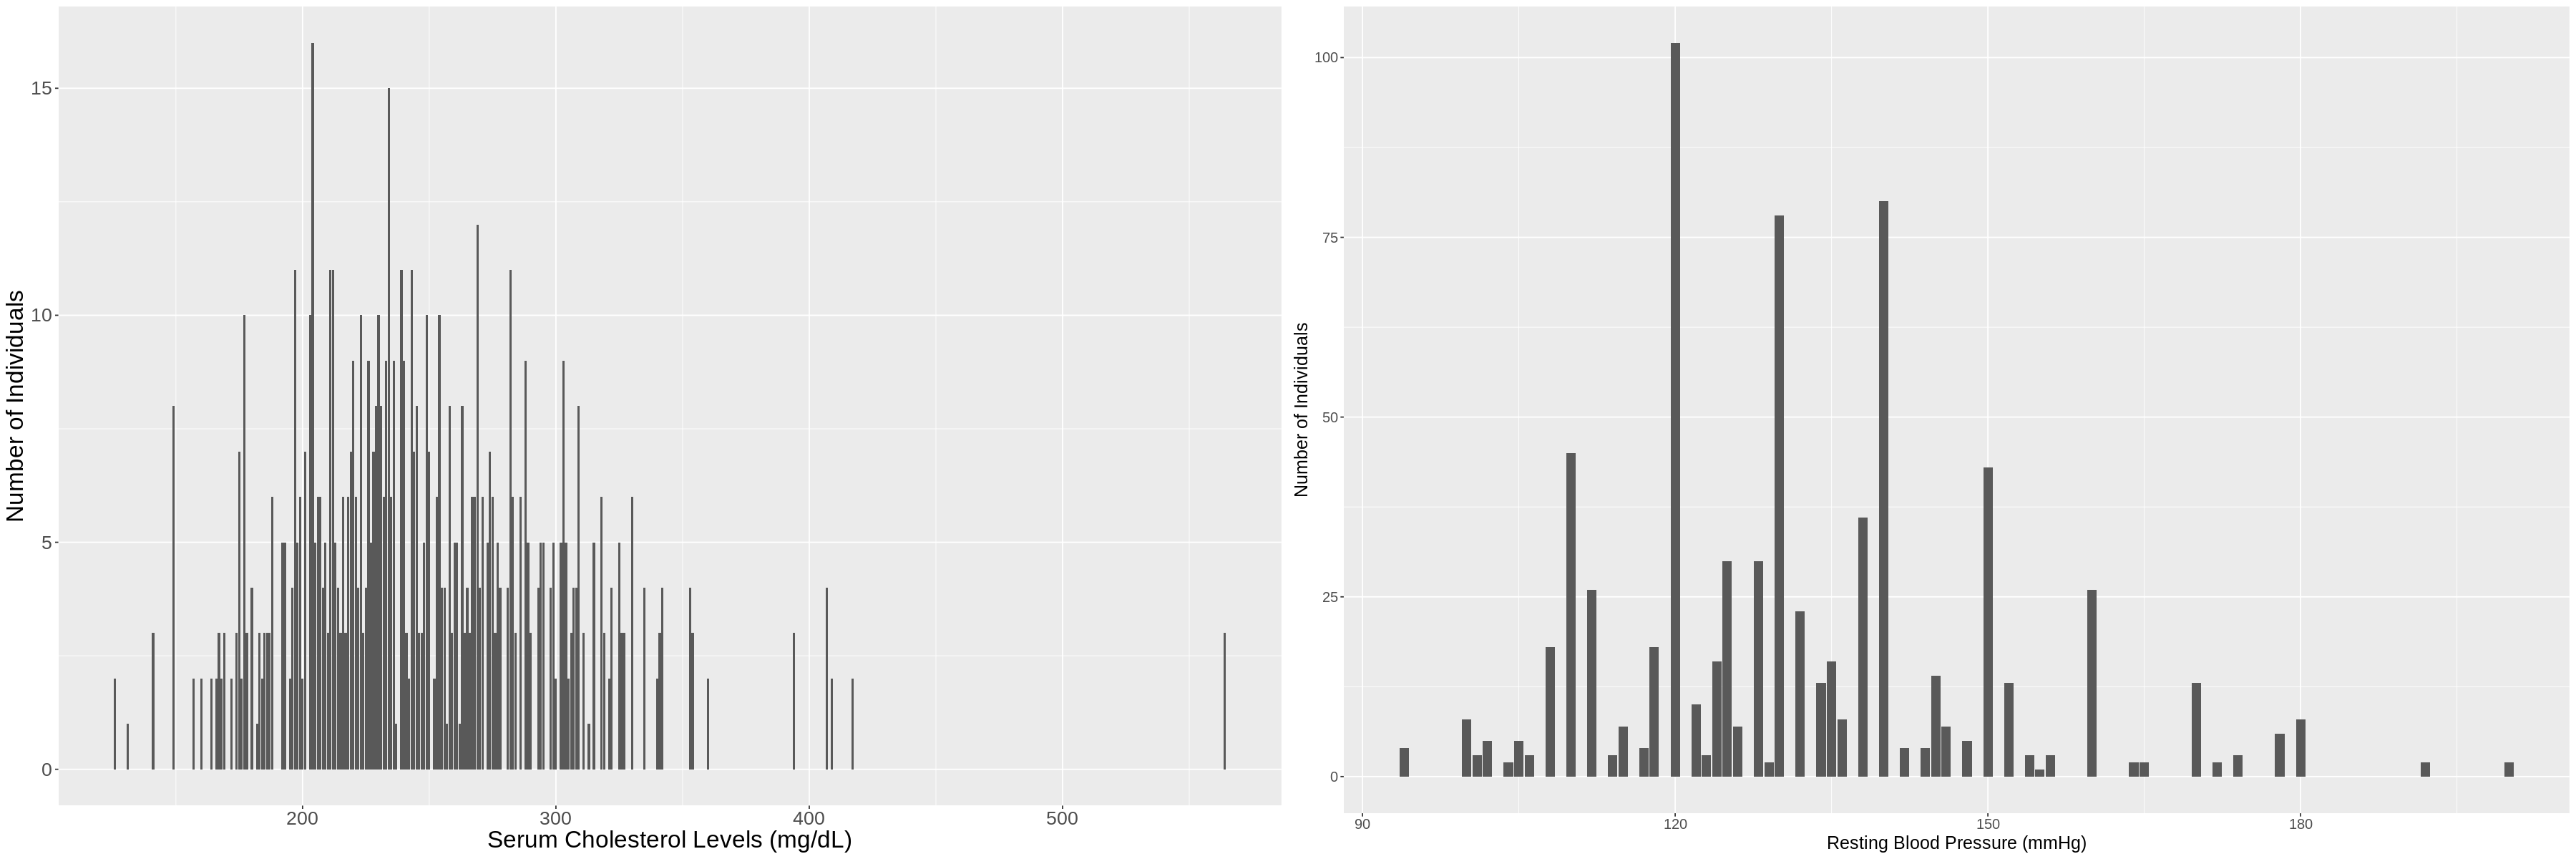

In [35]:
options(repr.plot.width = 30, repr.plot.height = 10)

cp_plot <- ggplot(cp_val, aes(x = cp, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Chest Pain Type", y = "Number of People") +
  theme(text = element_text(size = 15))

exang_plot <- ggplot(exang_val, aes(x = exang, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Exercise Induced Angina", y = "Number of People") +
  theme(text = element_text(size = 15))

grid.arrange(cp_plot, exang_plot, ncol = 2)

chol_plot <-  ggplot(chol_val, aes(x = chol, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Serum Cholesterol Levels (mg/dL)", y = "Number of Individuals")+
  theme(text = element_text(size = 20))

trestbps_plot <-  ggplot(trestbps_val, aes(x = trestbps, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Individuals") +
  theme(text = element_text(size = 15))

grid.arrange(chol_plot, trestbps_plot, ncol = 2)

### Methods:


Generally, as age increases, the risk of heart disease also increases due to factors resulting from aging (NIH, 2023). Angina is a type of chest pain that is often associated with different types of heart disease with one being coronary artery disease (Mayo Clinic Staff, 2022). According to Medical New Today, a persons serum cholesterol level can indicated their risks of developing heart disease, making it a good variable to explore (Jennifer Huizen , 2021). Lastly, we wanted to look at resting blood pressure as, risks of heart disease tend to increase in people with higher resting blood pressures (Joseph A. Hill, M.D., Ph.D., 2016).

To predict whether a patient has heart disease, a classifier needs to be taught and trained to increase its accuracy. This will be done by first using the training data split previously in order to build an efficient and accurate model that we can test using the testing set. This will ensure that the test data does not influence the classifier model being trained.
Since the K-nearest neighbors classification algorithm will be used, the most ideal value of K will be determined by performing
v-fold cross-validation with 5 folds. The K value that yields the most optimal accuracy, and does not drastically 
change the estimated accuracy when decreasing or increasing K by a small amount will be the best option. The K-nearest neighbors 
classifier object will be used to predict the class labels of the test set and predict whether there is a presence of heart disease in the 
patient. The patient will be evaluated with an integer value of 0 or 1 in the "target" field; 0 = no disease; 1 = disease.
The variables considered in the data analysis will be: age, exercise induced angina, serum cholesterol levels, chest pain, and resting blood pressure. To visualize our findings, we can use pie charts to show the perentage of correct and incorrect classifications in a distinct manner. 


### Expected outcomes and significance:


We are hoping to find a model that can predict the presence of heart disease based on the variables chosen with limited error. This could help lead to earlier diagnoses of heart disease and increase the chances of recovery and/or survival. Recognizing the possibility of heart disease early on is important for patients, and thus, this project will allow for recognition of patterns seen in the five variables that may indicate the possibility of heart disease in younger patients. This type of model could lead to future questions of how prevalent death by heart disease will be, and how the rate of survival from heart disease might change.

### Bibliography:

Lapp, D. (2019, June 6). Heart disease dataset. Kaggle. Retrieved March 6, 2023, from https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download 

Mayo Foundation for Medical Education and Research. (2022, March 30). Angina. Mayo Clinic. Retrieved March 9, 2023, from https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373#:~:text=Angina%20(an%2DJIE%2Dnuh,or%20pain%20in%20the%20chest. 

MediLexicon International. (n.d.). Serum cholesterol: What to know and how to manage levels. Medical News Today. Retrieved March 9, 2023, from https://www.medicalnewstoday.com/articles/321519#:~:text=A%20person's%20serum%20cholesterol%20level,of%20fat%20bundled%20with%20cholesterol. 

Types of heart disease. Heart and Stroke Foundation of Canada. (n.d.). Retrieved March 7, 2023, from https://www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease 

U.S. Department of Health and Human Services. (n.d.). Heart health and aging. National Institute on Aging. Retrieved March 8, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging#:~:text=Adults%20age%2065%20and%20older,risk%20of%20developing%20cardiovascular%20disease. 

Under pressure: How blood pressure affects heart disease risk: Heart: UT southwestern medical center. Heart | UT Southwestern Medical Center. (n.d.). Retrieved March 9, 2023, from https://utswmed.org/medblog/high-blood-pressure-heart-disease/#:~:text=For%20the%20average%20person%20who,at%20risk%20for%20heart%20disease. 